In [1]:
import sys
sys.path.append("..")

from utils import marker_sg_token, marker_pl_token

/nlp/scr/kallini/miniconda3/envs/llmenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Here is the final code used for the analysis and visualization:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Function to process each file and compute accuracy


def process_file(file_path, ckpt):
    df = pd.read_csv(file_path)
    df = df[df['ckpt'] == ckpt]

    # Separate the data for marker tokens
    token_marker_sg = df[df['token'] == marker_sg_token]
    token_marker_pl = df[df['token'] == marker_pl_token]

    # Merge the two datasets
    merged_df = pd.merge(token_marker_sg, token_marker_pl, on=[
                         'example', 'layer', 'pos', 'type'], suffixes=('_marker_sg', '_marker_pl'))

    # Compute correctness
    merged_df['correctness'] = (
        merged_df['prob_marker_pl'] > merged_df['prob_marker_sg']).astype(int)

    # Compute accuracy for each layer and pos
    merged_df = merged_df.groupby(['layer', 'pos']).agg(
        accuracy=('correctness', 'mean')).reset_index()
    merged_df['accuracy'] = merged_df['accuracy'] * 100

    return merged_df


def plot_intervention_accuracies(perturbation, seeds, ckpt, custom_x_labels, title=None, pos_encodings=True):

    if pos_encodings:
        nps = ""
    else:
        nps = "_no_pos_encodings"
    base_path = 'hop_intervention_results/{}_100M{}'.format(perturbation, nps) \
        + '/randinit_seed{}.csv'

    # Process each file
    all_accuracy_data = pd.concat(
        [process_file(base_path.format(s), ckpt) for s in seeds])

    # Compute mean accuracy and 95% confidence intervals
    grouped_data = all_accuracy_data.groupby(['layer', 'pos'])
    mean_accuracy = grouped_data['accuracy'].mean()
    sem_accuracy = grouped_data['accuracy'].sem()

    # Calculate confidence interval using t-distribution
    ci_lower, ci_upper = stats.t.interval(0.95, df=len(
        seeds)-1, loc=mean_accuracy, scale=sem_accuracy + 1e-6)

    # Preparing data for heatmap
    final_data = pd.DataFrame({
        'layer': mean_accuracy.index.get_level_values(0),
        'pos': mean_accuracy.index.get_level_values(1),
        'mean_accuracy': mean_accuracy.values,
        'ci': (ci_upper - ci_lower) / 2,
    })

    heatmap_data = final_data.pivot(
        index='layer', columns='pos', values='mean_accuracy')
    ci_data = final_data.pivot(index='layer', columns='pos', values='ci')

    # Plotting the heatmap
    if perturbation == "hop_control":
        plt.figure(figsize=(4, 4))
    else:
        plt.figure(figsize=(8, 4))

    heatmap = sns.heatmap(
        heatmap_data.iloc[::-1], annot=True, fmt=".2f", cmap="viridis", vmin=0.0, vmax=100.0, cbar=False)
    if title:
        plt.title(title)
    plt.xlabel(None)
    plt.ylabel(None)
    # plt.title("IIA", fontsize=12)

    # Setting custom X labels
    heatmap.set_xticklabels(custom_x_labels)

    # Annotate with confidence intervals
    for i, row in enumerate(heatmap_data.iloc[::-1].itertuples()):
        for j, val in enumerate(row[1:]):
            ci_val = ci_data.iloc[::-1].iat[i, j]
            text = heatmap.texts[i * len(row[1:]) + j]
            text.set_text(f'{val:.1f}±{ci_val:.1f}')


### With Positional Encodings

Checkpoint: 300


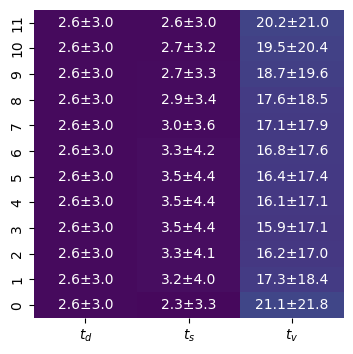

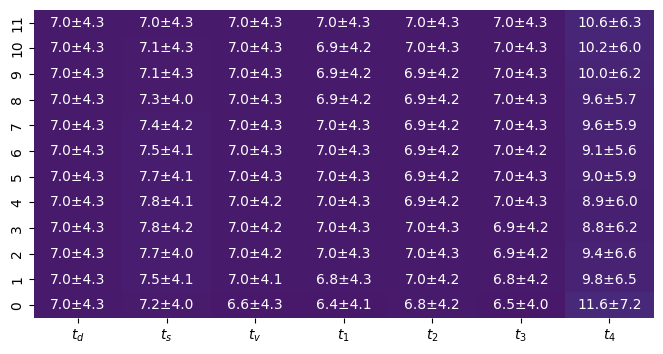

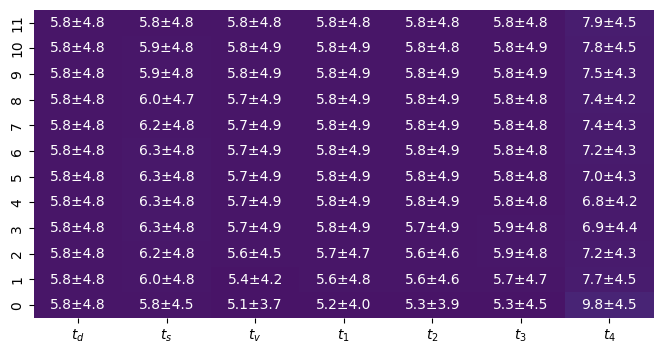

Checkpoint: 600


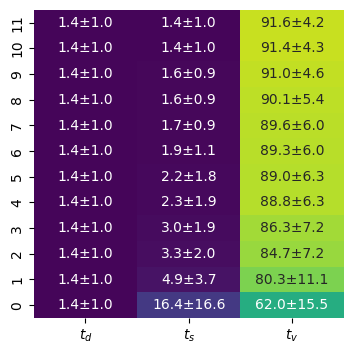

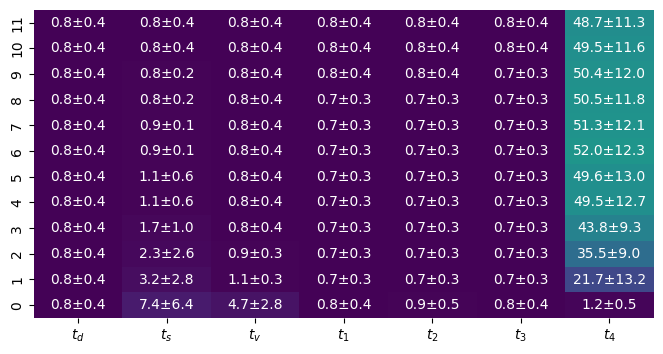

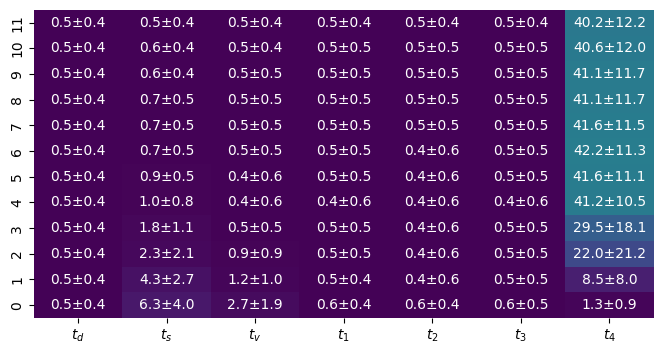

Checkpoint: 900


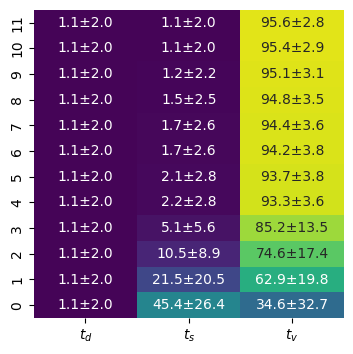

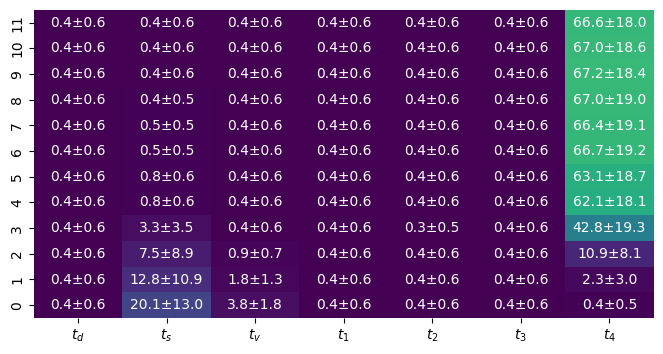

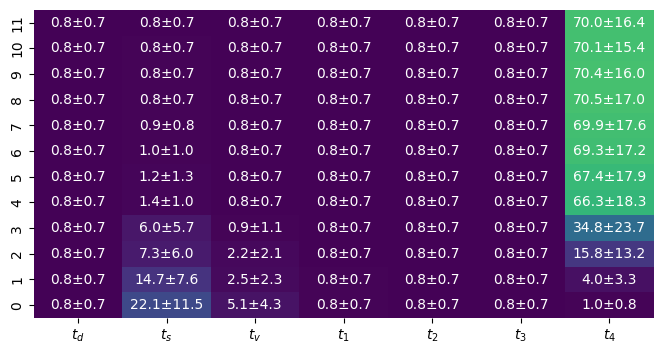

Checkpoint: 1200


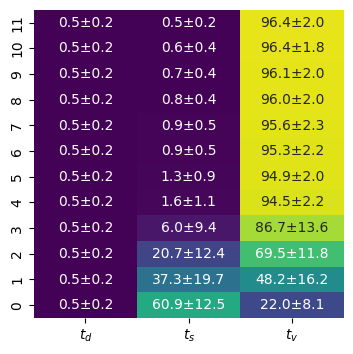

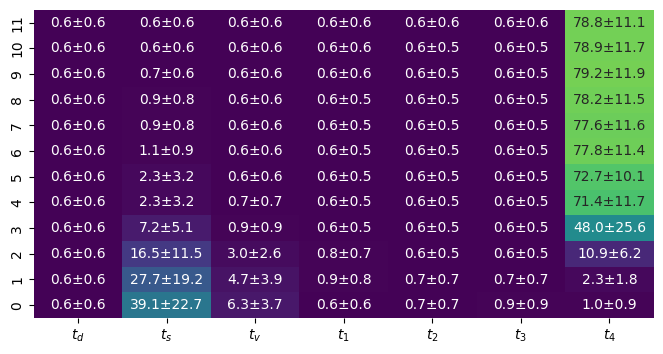

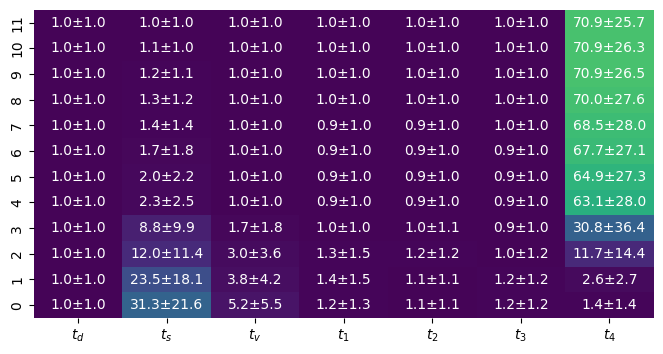

Checkpoint: 1500


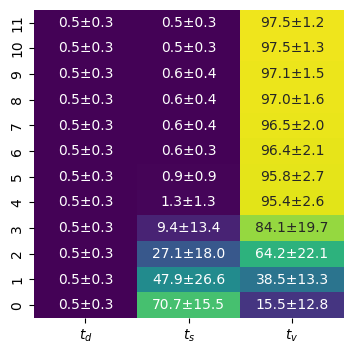

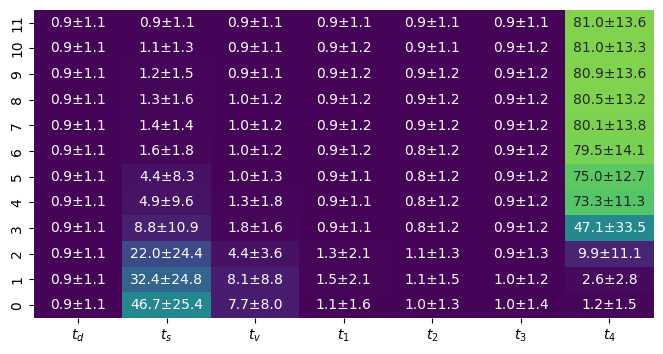

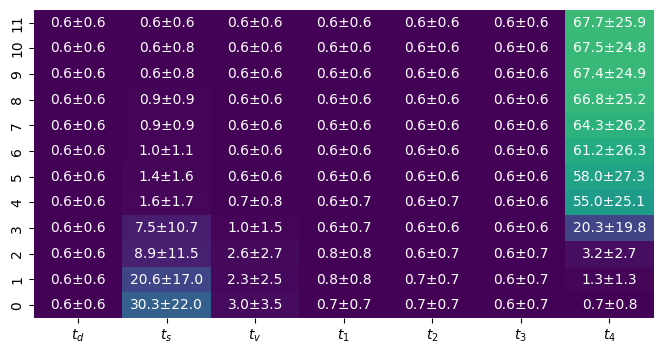

Checkpoint: 3000


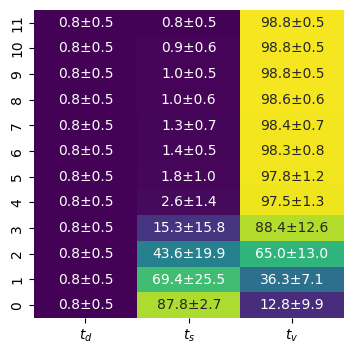

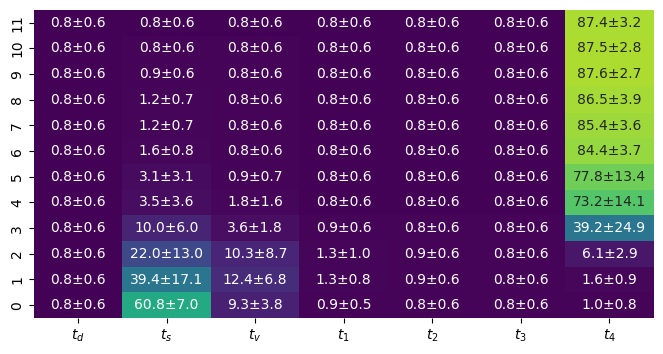

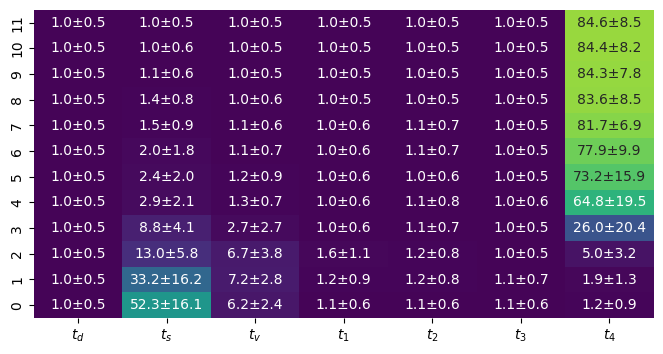

In [3]:
SEEDS = [0, 14, 41, 53, 96]
CHECKPOINTS = [300, 600, 900, 1200, 1500, 3000]

for ckpt in CHECKPOINTS:
    print(f"Checkpoint: {ckpt}")
    
    # Hop Control
    plot_intervention_accuracies("hop_control", SEEDS, ckpt, ["$t_{d}$", "$t_{s}$", "$t_{v}$"])
    plt.savefig(f"figures/ci_figures/IIA_CIs_hop_control_ckpt{ckpt}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    # Hop Tokens
    plot_intervention_accuracies("hop_tokens4", SEEDS, ckpt, [
                                "$t_{d}$", "$t_{s}$", "$t_{v}$", "$t_1$", "$t_2$", "$t_3$", "$t_4$"])
    plt.savefig(f"figures/ci_figures/IIA_CIs_hop_tokens4_ckpt{ckpt}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    # Hop Words
    plot_intervention_accuracies("hop_words4", SEEDS, ckpt, [
                                "$t_{d}$", "$t_{s}$", "$t_{v}$", "$t_1$", "$t_2$", "$t_3$", "$t_4$"])
    plt.savefig(f"figures/ci_figures/IIA_CIs_hop_words4_ckpt{ckpt}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

## Tighter Figure

In [4]:
def plot_intervention_accuracies_no_interval(perturbation, seeds, title, custom_x_labels, pos_encodings=True):

    fig, _ = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(5, 4))
    cbar_ax = fig.add_axes([1, .3, .03, .4])

    axs = fig.get_axes()

    if pos_encodings:
        nps = ""
    else:
        nps = "_no_pos_encodings"
    base_path = 'hop_intervention_results/{}_100M{}'.format(perturbation, nps) \
        + '/randinit_seed{}.csv'

    for i, ckpt in enumerate(CHECKPOINTS):
        # Process each file
        all_accuracy_data = pd.concat(
            [process_file(base_path.format(s), ckpt) for s in seeds])

        # Compute mean accuracy and 95% confidence intervals
        grouped_data = all_accuracy_data.groupby(['layer', 'pos'])
        mean_accuracy = grouped_data['accuracy'].mean()

        # Preparing data for heatmap
        final_data = pd.DataFrame({
            'Layer': mean_accuracy.index.get_level_values(0),
            'Position': mean_accuracy.index.get_level_values(1),
            'mean_accuracy': mean_accuracy.values,
        })

        heatmap_data = final_data.pivot(
            index='Layer', columns='Position', values='mean_accuracy')

        sns.heatmap(heatmap_data.iloc[::-1], annot=False, cbar=(i==0),
                    cbar_ax=None if i else cbar_ax,
                    ax=axs[i], vmin=-0.5, vmax=100.5, cmap="viridis")

        # Setting custom labels
        axs[i].set_xticklabels(custom_x_labels, fontsize=12)
        axs[i].tick_params(bottom=False, left=False, labelsize=12)
        axs[i].set_title(f"{ckpt} Steps", fontsize=12)
        axs[i].set_ylabel(None)
        axs[i].set_xlabel(None)

    # fig.colorbar(axs[0].collections[0])
    # fig.suptitle(title, y=1.05 if "\n" in title else 1, fontsize=14)
    fig.tight_layout()
    plt.title("IIA", fontsize=12)
    fig.suptitle(title, fontsize=16, y=1.05, x=0.53)
    # fig.supylabel("GPT-2 Layer of Intervention")
    # fig.supxlabel("Token Position of Intervention")


/tmp/user/23069/ipykernel_3350766/2802176381.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/user/23069/ipykernel_3350766/2802176381.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/user/23069/ipykernel_3350766/2802176381.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


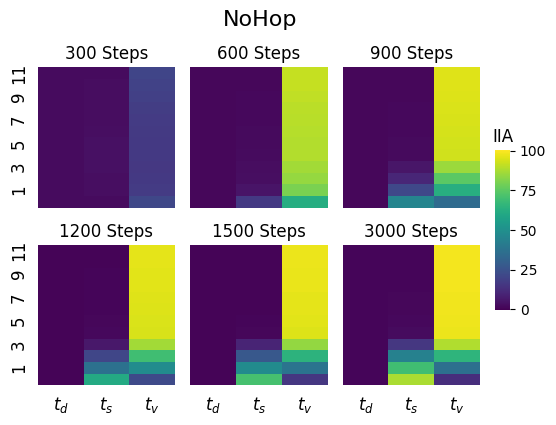

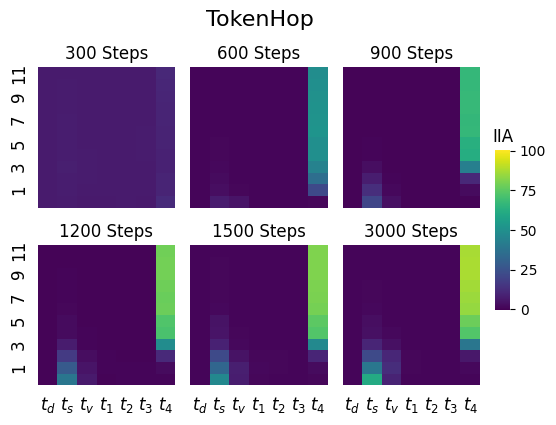

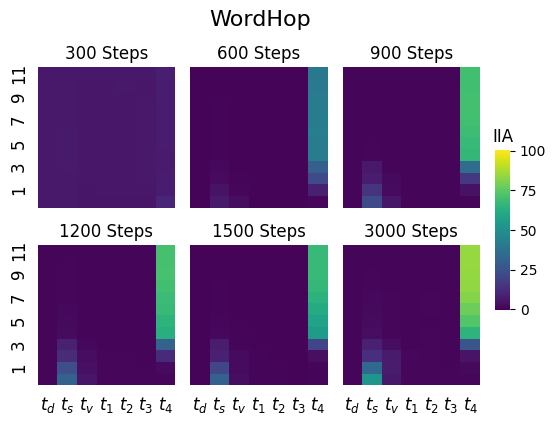

In [5]:
# File paths of the uploaded CSV files
plot_intervention_accuracies_no_interval("hop_control", SEEDS, "NoHop", ["$t_{d}$", "$t_{s}$", "$t_{v}$"])
plt.savefig("figures/IIA_hop_control_ckpts.pdf", format="pdf", bbox_inches="tight")

plot_intervention_accuracies_no_interval("hop_tokens4", SEEDS, "TokenHop", [
                             "$t_{d}$", "$t_{s}$", "$t_{v}$", "$t_1$", "$t_2$", "$t_3$", "$t_4$"])
plt.savefig("figures/IIA_hop_tokens4_ckpts.pdf", format="pdf", bbox_inches="tight")

plot_intervention_accuracies_no_interval("hop_words4", SEEDS, "WordHop", [
                             "$t_{d}$", "$t_{s}$", "$t_{v}$", "$t_1$", "$t_2$", "$t_3$", "$t_4$"])
plt.savefig("figures/IIA_hop_words4_ckpts.pdf", format="pdf", bbox_inches="tight")

### No Pos Encodings

/tmp/user/23069/ipykernel_3350766/2802176381.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/user/23069/ipykernel_3350766/2802176381.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/user/23069/ipykernel_3350766/2802176381.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


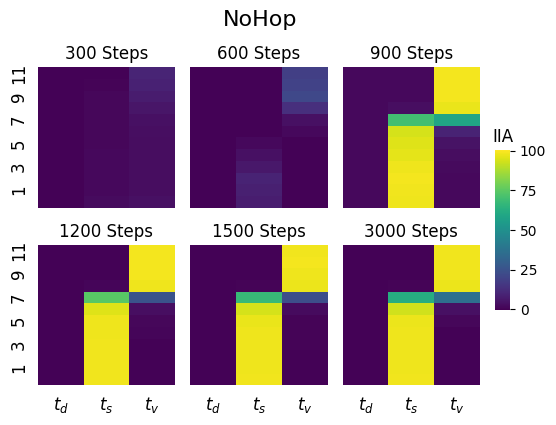

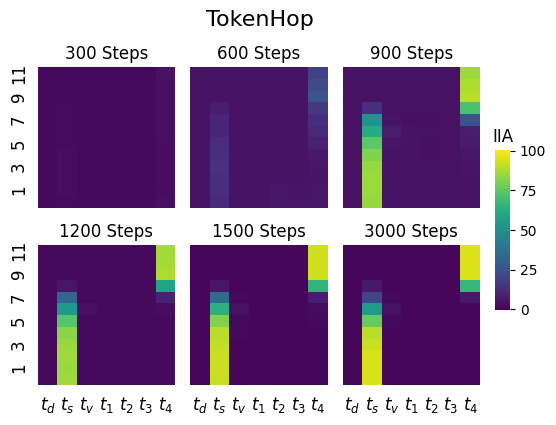

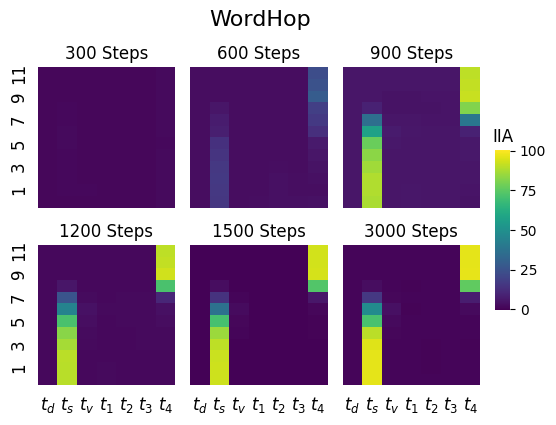

In [6]:
SEEDS = [53]
plot_intervention_accuracies_no_interval("hop_control", SEEDS, "NoHop", ["$t_{d}$", "$t_{s}$", "$t_{v}$"], pos_encodings=False)
plt.savefig("figures/IIA_hop_control_ckpts_no_pos_encodings.pdf", format="pdf", bbox_inches="tight")

plot_intervention_accuracies_no_interval("hop_tokens4", SEEDS, "TokenHop", [
                             "$t_{d}$", "$t_{s}$", "$t_{v}$", "$t_1$", "$t_2$", "$t_3$", "$t_4$"], pos_encodings=False)
plt.savefig("figures/IIA_hop_tokens4_ckpts_no_pos_encodings.pdf", format="pdf", bbox_inches="tight")

plot_intervention_accuracies_no_interval("hop_words4", SEEDS, "WordHop", [
                             "$t_{d}$", "$t_{s}$", "$t_{v}$", "$t_1$", "$t_2$", "$t_3$", "$t_4$"], pos_encodings=False)
plt.savefig("figures/IIA_hop_words4_ckpts_no_pos_encodings.pdf", format="pdf", bbox_inches="tight")